In [20]:
import pickle
import pandas as pd
import numpy as np
import os
from collections import Counter

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model, svm, naive_bayes, neighbors, ensemble
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB

In [7]:
# open feature engineered dataframe
with open('df_X2.pickle', 'rb') as read_file:
    df_X = pickle.load(read_file)

In [53]:
df_X.head(15)

,product_id,user_id,latest_cart,will_order,prod_total_orders,prod_avg_add_to_cart_order,prod_avg_days_since_prior_order,user_total_orders,user_avg_cartsize,user_total_products,user_avg_days_since_prior_order,user_avg_reorder_ratio,user_prod_avg_cart_order,user_prod_days_since_last,user_prod_order_freq,user_prod_latest_perc
0,1,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,1202,6,10.32610,5.0,38.0,135.0,5.708333,0.296875,20.0,8.0,0.2,0.2
1,196,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,22920,4,11.25590,5.0,38.0,135.0,5.708333,0.296875,25.0,8.0,0.4,0.4
2,223,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,99,5,9.97980,5.0,38.0,135.0,5.708333,0.296875,34.0,8.0,0.2,0.2
3,587,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,23,12,12.69570,5.0,38.0,135.0,5.708333,0.296875,25.0,8.0,0.2,0.2
4,955,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,143,10,11.36360,5.0,38.0,135.0,5.708333,0.296875,30.0,8.0,0.2,0.2
5,1219,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,209,10,10.40670,5.0,38.0,135.0,5.708333,0.296875,31.0,8.0,0.2,0.2
6,1519,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,274,10,11.47810,5.0,38.0,135.0,5.708333,0.296875,16.0,8.0,0.2,0.2
7,1582,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,745,9,11.49130,5.0,38.0,135.0,5.708333,0.296875,18.0,8.0,0.2,0.2
8,2202,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,294,11,12.37760,5.0,38.0,135.0,5.708333,0.296875,31.0,8.0,0.2,0.2
9,2491,709,"{45444, 32005, 26893, 8859, 28577, 48036, 1027...",0,12,10,7.08333,5.0,38.0,135.0,5.708333,0.296875,21.0,8.0,0.2,0.2


In [8]:
def get_user_split_data(df, test_size=.2, seed=42):

    rs = np.random.RandomState(seed)
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_te = df_tr['will_order'], df_te['will_order']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','will_order','user_total_orders', 'user_avg_cartsize', 'user_total_products'],axis=1) 
    X_te = df_te.drop(['product_id','user_id','latest_cart','will_order','user_total_orders', 'user_avg_cartsize', 'user_total_products'],axis=1)

    return X_tr, X_te, y_tr, y_te, df_tr,df_te

In [23]:
X_tr, X_te, y_tr, y_te, df_train, df_test = get_user_split_data(df_X)


In [24]:
def get_user_split_val(df, test_size=.25, seed=42):

    rs = np.random.RandomState(seed)
    total_users = df['user_id'].unique() 
    test_users = rs.choice(total_users, 
                           size=int(total_users.shape[0] * test_size), 
                           replace=False)

    df_tr = df[~df['user_id'].isin(test_users)]
    df_te = df[df['user_id'].isin(test_users)] 

    y_tr, y_val = df_tr['will_order'], df_te['will_order']
    X_tr = df_tr.drop(['product_id','user_id','latest_cart','will_order','user_total_orders', 'user_avg_cartsize', 'user_total_products'],axis=1) 
    X_val = df_te.drop(['product_id','user_id','latest_cart','will_order','user_total_orders', 'user_avg_cartsize', 'user_total_products'],axis=1)

    return X_tr, X_val, y_tr, y_val


In [25]:
X_train, X_val, y_train, y_val = get_user_split_val(df_train)

In [26]:
from imblearn.under_sampling import RandomUnderSampler
#imbalance and because want to be able to run data
X_under, y_under = RandomUnderSampler(random_state=42).fit_sample(X_train,y_train)


In [27]:
Counter(y_under)

Counter({0: 99305, 1: 99305})

In [21]:
xgb_model=xgb.XGBClassifier(learning_rate=0.01,max_depth=3)
lr_model = LogisticRegression(solver="liblinear",C=0.01)
nb_model = GaussianNB()
# knn_model = KNeighborsClassifier()
rf_model = RandomForestClassifier(n_estimators=500,max_depth=2)
ada_model = ensemble.AdaBoostClassifier()

model_names = ["xgb_model","lr_model", "nb_model", "rf_model", "ada_model"]
models = [xgb_model,lr_model, nb_model, rf_model, ada_model]

In [28]:
# ## Loop through each type of model and record cv score
f1_scores = []
for m in models:
    model_score = cross_val_score(m, X_under, y_under, cv=3, scoring='f1')
    f1_scores.append([np.mean(model_score), np.std(model_score)])
# look at st dev
print(f1_scores)
# XGB: 0.6978 LR: 0.5433 NB: 0.3732 RF: 0.6917 ADA: 0.7184

[[0.6977556313756454, 0.015785451499670252], [0.5432524133970127, 0.03490124400928615], [0.37322899446243024, 0.021340100439112608], [0.6917444800037655, 0.02882462020153244], [0.7184239199780599, 0.01981970766522001]]


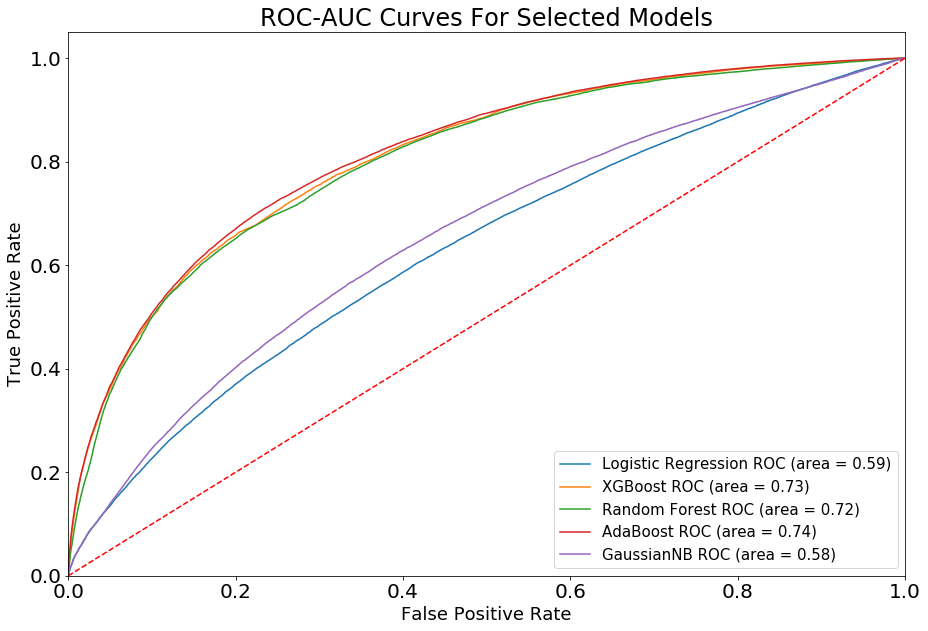

[0.22585798905753085, 0.3562668452865094, 0.3815954035526551, 0.3606694495860472, 0.22862691680041]


In [34]:
import matplotlib.pyplot as plt

roc_fig = plt.figure(figsize=(15,10))

models = [
{
    'label': 'Logistic Regression',
    'model': LogisticRegression(solver='liblinear',C=0.01),
},
{
    'label': 'XGBoost',
    'model': xgb.XGBClassifier(learning_rate=0.01,max_depth=3),
},
{
    'label': 'Random Forest',
    'model': RandomForestClassifier(n_estimators=500,max_depth=2),
},
{
    'label': 'AdaBoost',
    'model': ensemble.AdaBoostClassifier(),
},
{
    'label': 'GaussianNB',
    'model': GaussianNB(),
}
    
]

val_f1_scores = []
for m in models:
    model = m['model'] # select the model
    model.fit(X_under, y_under) # train the model
    y_pred=model.predict(X_val)
    f1score = metrics.f1_score(y_val, model.predict(X_val))
    val_f1_scores.append(f1score)
    fpr, tpr, thresholds = metrics.roc_curve(y_val, model.predict_proba(X_val)[:,1])
    auc = metrics.roc_auc_score(y_val,model.predict(X_val))
    plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (m['label'], auc))
    
# Custom settings for the plot 
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.legend(loc="lower right",prop={'size': 15})
plt.rcParams.update({'font.size': 20})
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('ROC-AUC Curves For Selected Models')
plt.show()
roc_fig.savefig('instacart_roc_auc_3.svg', transparent=True)

print(val_f1_scores)

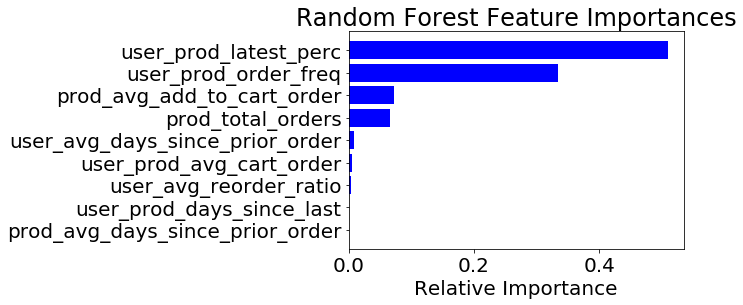

In [35]:
rf_val = RandomForestClassifier(n_estimators=500,max_depth=2)
rf_val.fit(X_under,y_under)
rf_val.predict(X_val)
val_features = X_under.columns
val_importances = rf_val.feature_importances_
indices = np.argsort(val_importances)

plt.title('Random Forest Feature Importances')
plt.barh(range(len(indices)), val_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [val_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
def xgboost_run(X,y,X_val,y_val):
    xgb_model.fit(X,y)
    xgb_model.predict(X_val)
    f1score = metrics.f1_score(y_val, xgb_model.predict(X_val))
    accuracy_xgb = metrics.accuracy(y_val, xgb_model.predict(X_val))
    recall_xgb = metrics.recall_score(y_val, xgb_model.predict(X_val))
    return f1score, accuracy_xgb, recall_xgb

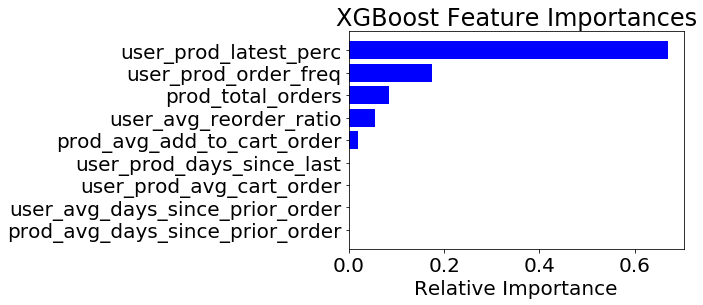

In [36]:
val_features = X_under.columns
val_importances = xgb_model.feature_importances_
indices = np.argsort(val_importances)

plt.title('XGBoost Feature Importances')
plt.barh(range(len(indices)), val_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [val_features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [50]:
scores_dict = {}
for m in models:
    model = m['model'] # select the model
    name = m['label']
    scores_dict[name] = {'accuracy':None,'f1':None,'recall':None,'precision':None}
    model.fit(X_under, y_under)
    y_pred_test=model.predict(X_te) # predict the test data
    scores_dict[name]['accuracy'] = model.score(X_te, y_te)
    scores_dict[name]['f1'] = metrics.f1_score(y_te, y_pred_test)
    scores_dict[name]['recall'] = metrics.recall_score(y_te,y_pred_test)
    scores_dict[name]['precision'] = metrics.precision_score(y_te,y_pred_test)


In [41]:
print(scores_dict)

{'Logistic Regression': {'f1': 0.23030967875832012, 'recall': 0.45716976135126386, 'precision': 0.15392694018686032}, 'XGBoost': {'f1': 0.36875905703855627, 'recall': 0.6851661124679987, 'precision': 0.2522643553629469}, 'Random Forest': {'f1': 0.3985088032759969, 'recall': 0.607097666480299, 'precision': 0.2966013973949797}, 'AdaBoost': {'f1': 0.36836237039509107, 'recall': 0.7145631639349086, 'precision': 0.24814020028612302}, 'GaussianNB': {'f1': 0.22841707752019302, 'recall': 0.25630462289968514, 'precision': 0.206002696246541}}


In [51]:
scores = pd.DataFrame(scores_dict) 

In [52]:
scores

,Logistic Regression,XGBoost,Random Forest,AdaBoost,GaussianNB
accuracy,0.699184,0.769077,0.813937,0.758758,0.829537
f1,0.230310,0.368759,0.395429,0.368362,0.228417
recall,0.457170,0.685166,0.618103,0.714563,0.256305
precision,0.153927,0.252264,0.290703,0.248140,0.206003


In [ ]:
xgb_test.fit(X_under,y_under)
y_pred_xgb = xgb_test.predict(X_te)
xgb_model.predict_proba(X_te)

In [45]:
#df_X.to_csv('another_df.csv',index=False)